In [30]:
from subpred.protein_go_datasets import get_transmembrane_transporter_dataset, get_stats

Stats on all proteins

In [31]:
dataset_athaliana = get_transmembrane_transporter_dataset(  # athaliana
    organism_ids=[3702],
    swissprot_only=False,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=False,
    max_sequence_evidence_code=2,
    remove_proteins_without_gene_names=False,
)
get_stats(*dataset_athaliana)

cd-hit: clustered 1773 sequences into 646 clusters at threshold 50
cd-hit: clustered 1773 sequences into 923 clusters at threshold 70
cd-hit: clustered 1773 sequences into 1203 clusters at threshold 90
cd-hit: clustered 1773 sequences into 1554 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence   protein_existence_evidence clustering                   
False              False         computational protein_level              100                      3   
                                                                          None                     3   
                                               transcript_level           50                       3   
                                                                          70                       4   
                                                                          90                       7   
                                                                          100                     37   
                                                                          None                    49   
                   True          computational protein_level              50                      87   
                                                                          70                     114   
                                                                          90                     153   
                                                                          100                    329   
                                                                          None                   433   
                                               transcript_level           50                       7   
                                                                          70                      13   
                                                                          90                      19   
                                                                          100                     84   
                                                                          None                   164   
                                 experiment    protein_level              50                      25   
                                                                          70                      33   
                                                                          90                      38   
                                                                          100                     41   
                                                                          None                    42   
                                               transcript_level           50                       3   
                                                                          70                       5   
                                                                          90                       5   
                                                                          100                      6   
                                                                          None                     6   
True               True          computational protein_level              50                     206   
                                                                          70                     287   
                                                                          90                     370   
                                                                          100                    408   
                                                                          None                   418   
                                               transcript_level           50                     208   
                                                                          70                     338   
                                                                          90                     462   
                                                                          100                    492   
                                                                          None                   504   
                              

Subset

In [32]:
dataset_athaliana = (
    get_transmembrane_transporter_dataset(  # athaliana
        organism_ids=[3702],
        swissprot_only=True,
        datasets_path="../data/datasets/",
        exclude_iea_go_terms=True,
        max_sequence_evidence_code=1,
        remove_proteins_without_gene_names=True,
    )
)
get_stats(*dataset_athaliana)

cd-hit: clustered 420 sequences into 276 clusters at threshold 50
cd-hit: clustered 420 sequences into 344 clusters at threshold 70
cd-hit: clustered 420 sequences into 403 clusters at threshold 90
cd-hit: clustered 420 sequences into 419 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering                   
True               True          experiment  protein_level              50                     276   
                                                                        70                     344   
                                                                        90                     403   
                                                                        100                    419   
                                                                        None                   420   

                                                                                    n_terms  
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering           
True               True          experiment  protein_level              50              264  
                                                                        70              281  
                                                                        90              288  
                                                                        100             288  
                                                                        None            288

Sugar/Amino subset

In [33]:
df_sequences_athaliana, df_goa_athaliana = dataset_athaliana
df_goa_athaliana = (
    df_goa_athaliana[
        df_goa_athaliana.go_term_ancestor.isin(
            [
                "sugar transmembrane transporter activity",
                "amino acid transmembrane transporter activity",
            ]
        )
    ][["Uniprot", "go_term_ancestor"]]
    .drop_duplicates()
    .reset_index(drop=True)
)  # .go_term_ancestor.value_counts()
df_sequences_athaliana = df_sequences_athaliana[
    df_sequences_athaliana.index.isin(df_goa_athaliana.Uniprot)
]


df_goa_athaliana.go_term_ancestor.value_counts()

# clustering before or after?

# TCDB identifiers

go_term_ancestor
amino acid transmembrane transporter activity    33
sugar transmembrane transporter activity         32
Name: count, dtype: int64

In [34]:
from subpred.cdhit import cd_hit

cluster_representatives_70 = set(cd_hit(
    df_sequences_athaliana.sequence, identity_threshold=70
))
df_sequences_athaliana = df_sequences_athaliana[df_sequences_athaliana.index.isin(cluster_representatives_70)]
df_goa_athaliana = df_goa_athaliana[df_goa_athaliana.Uniprot.isin(cluster_representatives_70)]
df_goa_athaliana.go_term_ancestor.value_counts()

cd-hit: clustered 65 sequences into 54 clusters at threshold 70


go_term_ancestor
sugar transmembrane transporter activity         28
amino acid transmembrane transporter activity    26
Name: count, dtype: int64

In [35]:
dataset_athaliana = (df_sequences_athaliana, df_goa_athaliana)

Features

Plots

In [ ]:
from subpred.features import calculate_features
from subpred.compositions import calculate_comp, ALPHABET_3DI
from subpred.structural_sequences import get_3Di_sequences
from subpred.embeddings import get_nlp_features
from sklearn.preprocessing import scale
import pandas as pd



# TODO use PSSM and KMER features separately!
dataset_sequences, dataset_uniprot = dataset_athaliana
# original sequences features
df_features_std = calculate_features(
    dataset_sequences.sequence, standardize_samples=True
)
df_features_nonstd = calculate_features(
    dataset_sequences.sequence, standardize_samples=False
)


# 3Di sequence features

# TODO turn into method
standardize_samples_3Di = False
sequences_3Di = get_3Di_sequences(dataset_sequences.index)
df_3Di_AAC = calculate_comp(sequences=sequences_3Di, k=1, alphabet=ALPHABET_3DI)
df_3Di_PAAC = calculate_comp(sequences=sequences_3Di, k=2, alphabet=ALPHABET_3DI)
df_3Di_KMER3 = calculate_comp(sequences=sequences_3Di, k=3, alphabet=ALPHABET_3DI)

features_3Di = [df_3Di_AAC, df_3Di_PAAC, df_3Di_KMER3]
if standardize_samples_3Di:
    features_list = [
        pd.DataFrame(
            data=scale(feature, axis=1),
            index=feature.index,
            columns=feature.columns,
        )
        for feature in features_3Di
    ]
df_features_3Di = pd.concat(
    features_list,
    axis=1,
)

# AA Embeddings
df_embeddings_prott5_AA = get_nlp_features(
    sequences=dataset_sequences.sequence,
    model="protT5",
    sequence_type="AA",
    half_precision=True,
)
df_embeddings_prostt5_AA = get_nlp_features(
    sequences=dataset_sequences.sequence,
    model="prostT5",
    sequence_type="AA",
    half_precision=True,
)
# 3Di Embeddings
df_embeddings_prott5_3Di = get_nlp_features(
    sequences=sequences_3Di,
    model="prostT5",
    sequence_type="3Di",
    half_precision=True,
)

import numpy as np

np.random.seed(0)
df_dummy_feature = pd.DataFrame(
    np.random.rand(54, 1024),
    index=df_embeddings_prott5_AA.index,
    columns=[f"dummy{i}" for i in range(1024)],
)

In [53]:
from sklearn.preprocessing import LabelEncoder

def get_ml_dataset(df_features, df_goa):
    sample_names = df_features.index.to_numpy()
    feature_names = df_features.columns.to_numpy()
    series_labels = df_goa[df_goa.Uniprot.isin(sample_names)].set_index("Uniprot")

    assert not series_labels.index.duplicated().any()

    label_encoder = LabelEncoder()

    X = df_features.loc[sample_names].to_numpy()
    y_str = series_labels.loc[sample_names].to_numpy().ravel()
    y = label_encoder.fit_transform(y_str)

    return X,y,sample_names,feature_names

In [72]:
# X,y,sample_names,feature_names = get_ml_dataset(df_features_std)
X,y,sample_names,feature_names = get_ml_dataset(df_3Di_KMER3, df_goa_athaliana)

In [73]:
# # TODO check for outliers with one-class svm, and z-score. tell which distribution?

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

outlier_detector = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    IsolationForest(contamination="auto", random_state=0),
)
outliers = outlier_detector.fit_predict(X)  # -1 for outliers, 1 for inliers
print((outliers == -1).sum(), "outliers found")

remove_outliers=False
if remove_outliers:
    X = X[outliers != -1]
    y = y[outliers != -1]

0 outliers found


In [74]:
X.shape

(54, 8000)

RecursionError: maximum recursion depth exceeded

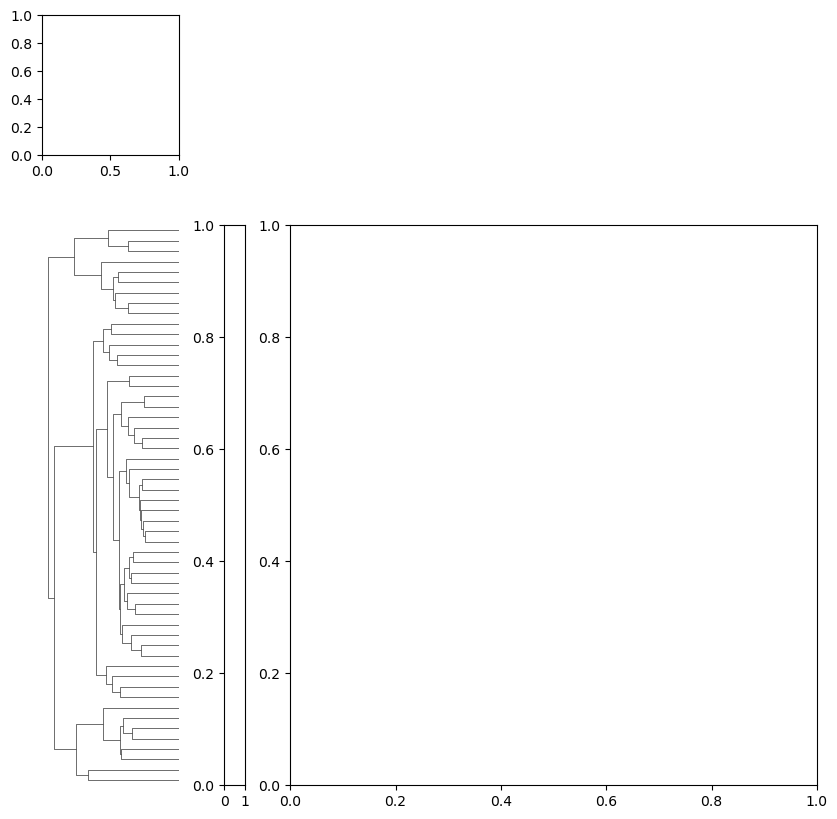

In [75]:
import seaborn as sns

sns.clustermap(X, row_colors=["yellow" if label == 1 else "blue" for label in y])

SVM model

In [ ]:
# from sklearn.compose import ColumnTransformer


# aac_cols = [i for i, col in enumerate(feature_names) if col.startswith("AAC")]
# paac_cols = [i for i, col in enumerate(feature_names) if col.startswith("PAAC")]
# pssm_cols = [i for i, col in enumerate(feature_names) if col.startswith("PSSM")]

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('aac', StandardScaler(), aac_cols),
#         ('paac', StandardScaler(), paac_cols),
#         ('logodds', StandardScaler(), pssm_cols)
#     ]
# )

In [80]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score,  RepeatedStratifiedKFold,StratifiedKFold, LeaveOneOut
from sklearn.metrics import f1_score, balanced_accuracy_score


model = make_pipeline(VarianceThreshold(),StandardScaler(),SelectKBest(), SVC())

max_features = int(np.sqrt(len(feature_names)))
# max_features = int(len(feature_names)/2)

param_grid = {
    "selectkbest__k": list(range(1,max_features,1)),
    "svc__class_weight" : ["balanced"]
    # "svc__C":[0.1, 1, 10],
    # "svc__gamma": ["scale", "auto", 0.1, 1, 10]
}

gridsearch = GridSearchCV(estimator=model, param_grid=param_grid, scoring="balanced_accuracy", cv=StratifiedKFold(3), n_jobs=-1)

gridsearch_results = gridsearch.fit(X,y)
print(gridsearch_results.best_score_)
print(gridsearch_results.best_params_)
df_results = pd.DataFrame(gridsearch_results.cv_results_)
display(df_results.filter(like="test_score", axis=1).sort_values("rank_test_score").head())

0.9421296296296297
{'selectkbest__k': 24, 'svc__class_weight': 'balanced'}


,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
23,0.9375,0.944444,0.944444,0.942130,0.003274,1
61,0.9500,0.944444,0.888889,0.927778,0.027592,2
62,0.9500,0.944444,0.888889,0.927778,0.027592,2
55,0.9500,0.944444,0.888889,0.927778,0.027592,2
51,0.9500,0.888889,0.944444,0.927778,0.027592,2


In [81]:
gridsearch.n_jobs = 1
cross_val_score(gridsearch, X, y, cv=RepeatedStratifiedKFold(n_splits=3, n_repeats=10, random_state=0), scoring="balanced_accuracy", n_jobs=-1).mean()

np.float64(0.890185185185185)

In [ ]:
# TODO linear svm, linear svm with nyström, DNN